# Calculando Largura de Vias

Neste Jupyter Notebook vamos validar a POC calculando a largura de vias para todo um distrito que possui Polígono de vias desenhado

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

In [2]:
# df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
# df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')

In [3]:
df_s = gpd.read_file(f'gis/SIRGAS_SHP_distrito_polygon.shp')
df_s = df_s[df_s['ds_nome'] == 'VILA MARIANA']

In [5]:
df_pvias = gpd.read_file("./resultado/poligono_de_vias.gpkg", layer='90 - poligono de vias de vila mariana')

## Limitando as vias que intersectam os poligonos

In [9]:
df_s_sindex = df_s.sindex
df_l_sindex = df_l.sindex

In [10]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
l_candidate_idx = list(df_l_sindex.intersection(bounds))
l_candidates = df_l.loc[l_candidate_idx]

In [11]:
df_l = gpd.clip(l_candidates, df_s)

/home/fernando/miniconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


## Criando pontos regulares sobre as linhas da via

In [20]:
import math
from shapely.geometry import MultiPoint

dist = 12.00

points = df_l.apply(lambda x: MultiPoint([x.geometry.interpolate(((i)*dist)+dist/2+(x.geometry.length%dist)/2) 
                                              for i in range(math.floor(x.geometry.length/dist))]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

## Relacionando o ponto ao seu polígono de via

In [23]:
gpd.sjoin(df_points, df_pvias, how='left', op='intersects')

,geometry,index_right
42020,GEOMETRYCOLLECTION EMPTY,NaN
171488,GEOMETRYCOLLECTION EMPTY,NaN
141164,GEOMETRYCOLLECTION EMPTY,NaN
21724,GEOMETRYCOLLECTION EMPTY,NaN
58551,GEOMETRYCOLLECTION EMPTY,NaN
...,...,...
198119,GEOMETRYCOLLECTION EMPTY,NaN
198113,"MULTIPOINT (331584.100 7389327.988, 331583.899...",2178.0
158482,MULTIPOINT (331575.382 7389335.902),2499.0
158486,MULTIPOINT (331575.384 7389335.944),2499.0


In [24]:
points = df_points.apply(lambda x: list(x.geometry.geoms), axis=1)
df_p = gpd.GeoDataFrame(geometry=[item for sublist in points for item in sublist])

In [28]:
df_points = gpd.sjoin(df_p, df_pvias, how='left', op='intersects', rsuffix='pvias')

## Quadras e canteiros

Para que possamos calcular a distância de cada um desses pontos gerados precisamos saber as mínimas distâncias para cada elemento que não seja via. Podemos chamar genericamente de quadras, porém existem canteiros tb.

In [42]:
df_nao_vias = gpd.overlay(gpd.GeoDataFrame(geometry=df_s.buffer(10)), df_pvias, how='difference')

In [54]:
# df_nao_vias.geometry.map(lambda x: list(x))
quadras = [item for sublist in df_nao_vias.geometry.map(lambda x: list(x)) for item in sublist]
df_quadras = gpd.GeoDataFrame(geometry=quadras)

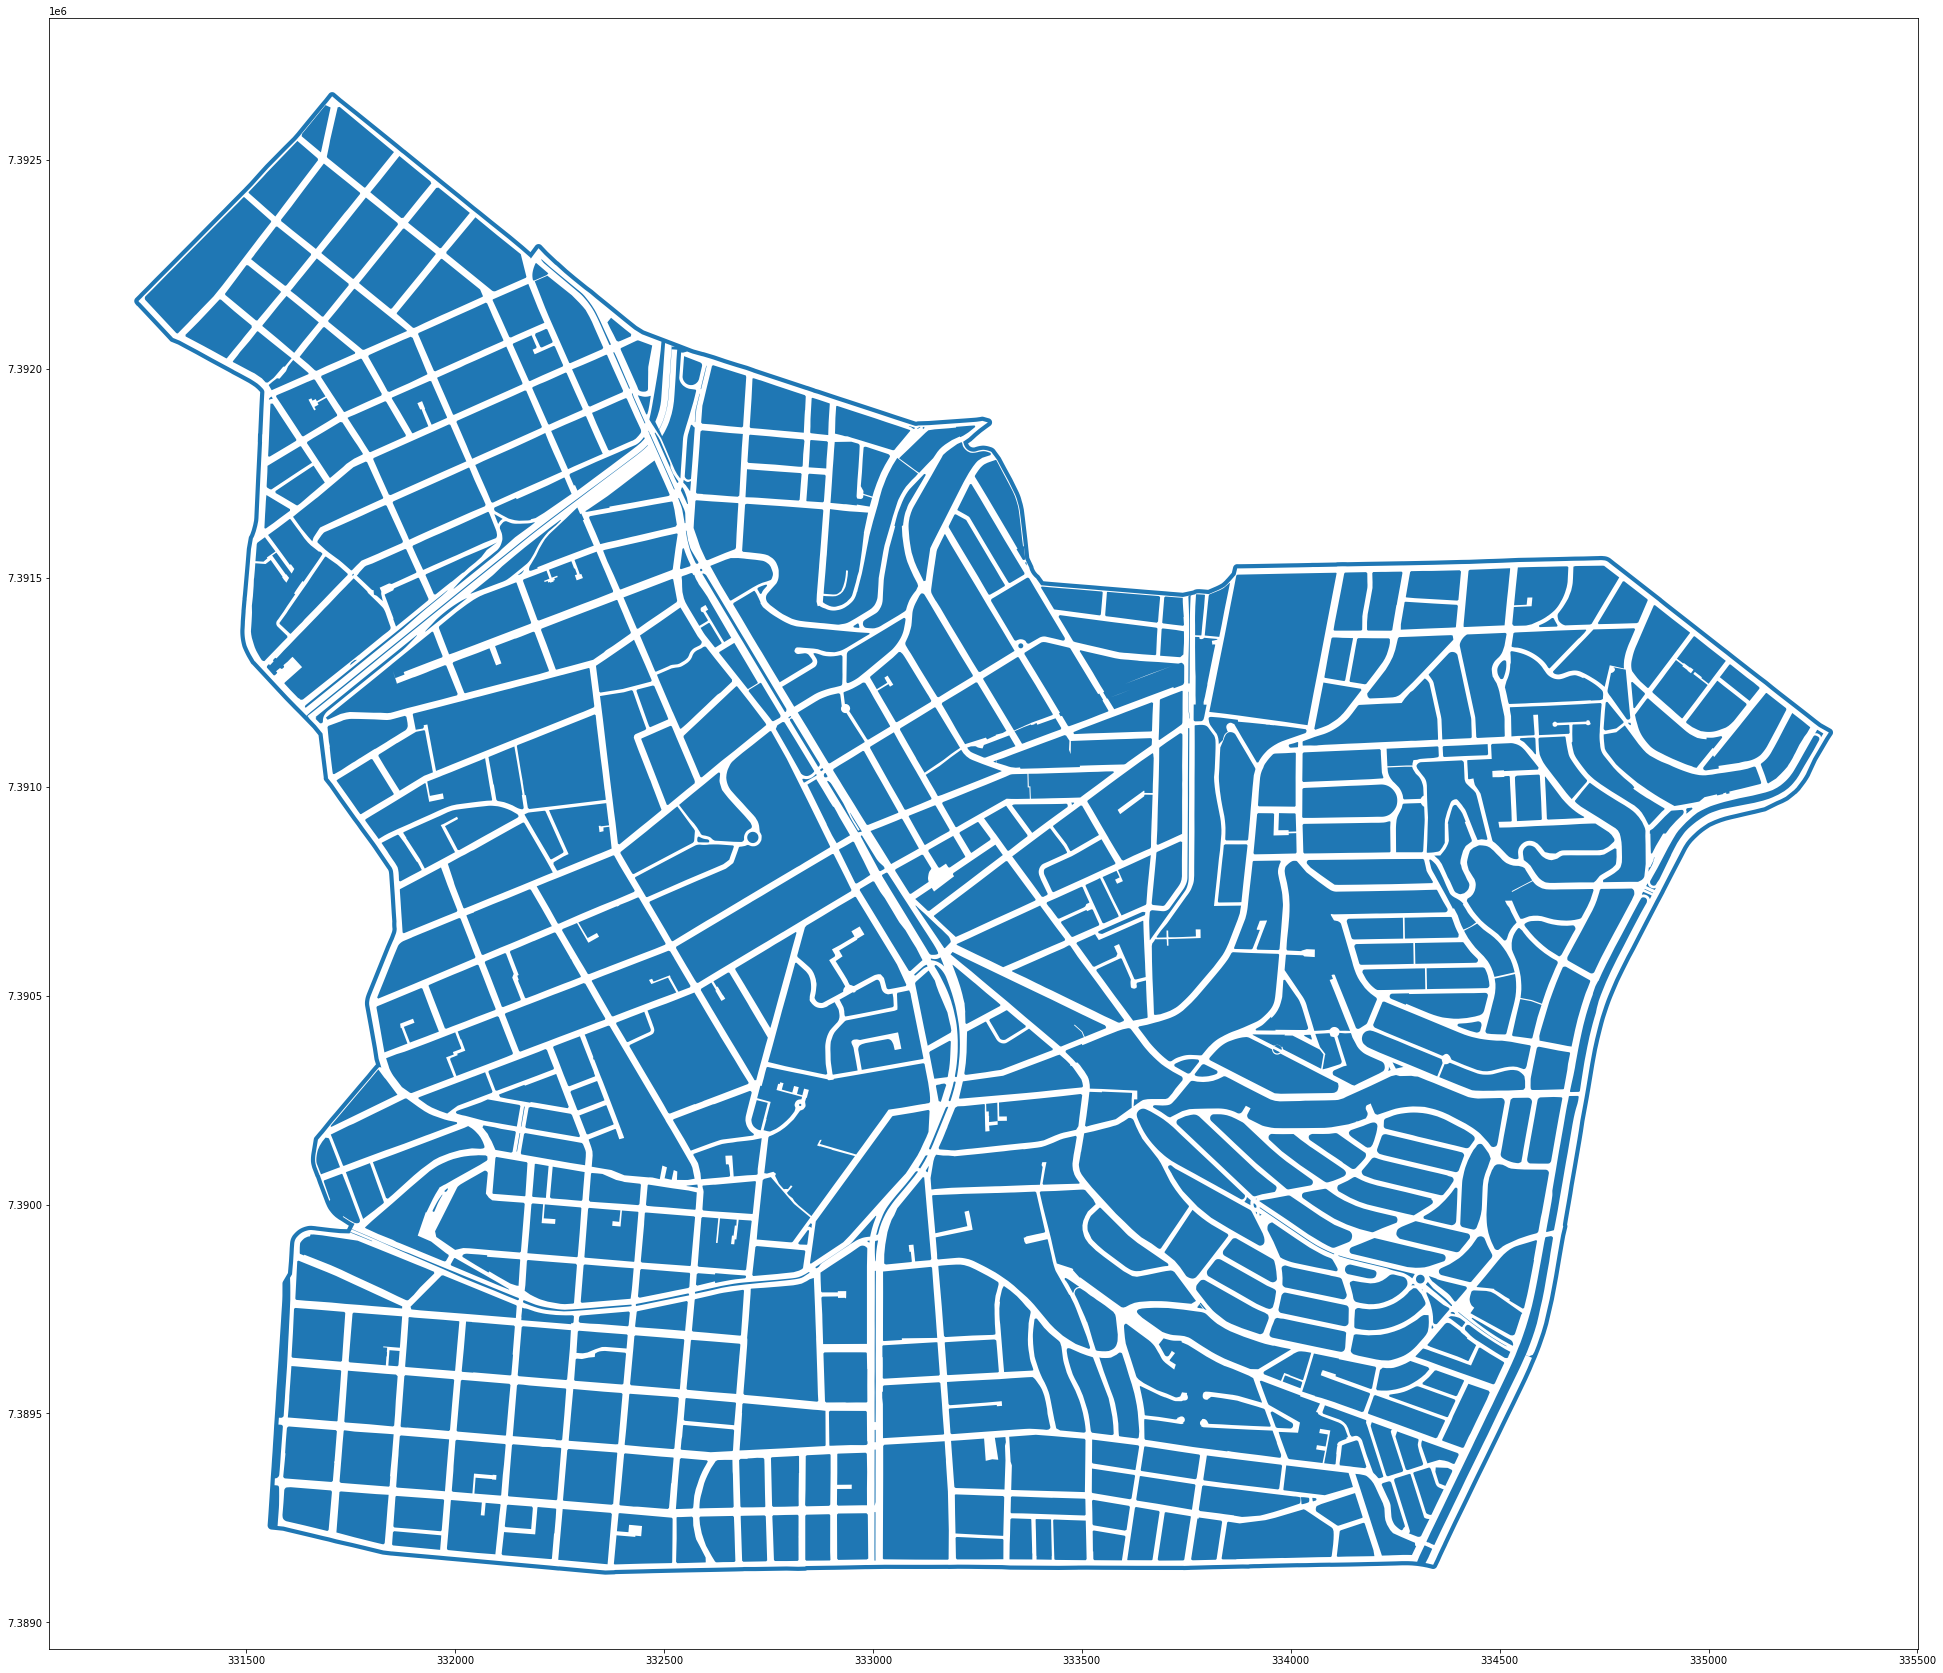

In [56]:
df_quadras.plot()

## Relacionando as quadras adjacentes ao polígono de vias

In [58]:
df_pvia_quadra = gpd.sjoin(df_pvias, df_quadras, how='left', op='intersects', rsuffix='quadra')
df_pvia_quadra.index.name = 'id'
df_pvia_quadra

,geometry,index_quadra
id,,
0,"POLYGON ((334111.804 7391527.195, 334123.792 7...",0.0
0,"POLYGON ((334111.804 7391527.195, 334123.792 7...",136.0
1,"POLYGON ((334188.583 7391528.284, 334217.988 7...",0.0
1,"POLYGON ((334188.583 7391528.284, 334217.988 7...",123.0
2,"POLYGON ((334265.635 7391529.569, 334268.445 7...",0.0
...,...,...
2604,"POLYGON ((334864.675 7390764.289, 334864.675 7...",NaN
2605,"POLYGON ((334862.206 7390759.633, 334861.739 7...",NaN
2606,"POLYGON ((334862.280 7390759.934, 334863.499 7...",NaN


## Calculando as distâncias

In [105]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split

In [115]:
def calc_distancia(p):
    quadras = list(df_pvia_quadra[df_pvia_quadra.index == p.index_pvias].index_quadra)
    quadras = df_quadras[df_quadras.index.isin(quadras)]
    pontos  = []
    
    for i, row in quadras.iterrows():
        pontos.append(nearest_points(p.geometry, row.geometry)[1])
    
    if len(pontos) == 2:   
        return LineString(pontos)
    elif len(pontos) > 2:  
        bd = split(MultiPoint(pontos).convex_hull.boundary, MultiPoint(pontos))
        return min(bd, key=(lambda x: x.length))
    else:
        return None
    

# df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))
ps = df_points.apply(lambda x: calc_distancia(x), axis=1)

In [116]:
ps

0        LINESTRING (332004.3906 7391875.5269, 331997.5...
1        LINESTRING (332014.6522417904 7391880.10680694...
2        LINESTRING (332025.6102356215 7391884.99763801...
3        LINESTRING (332036.5684806827 7391889.88838833...
4        LINESTRING (332047.5265782416 7391894.77917028...
                               ...                        
14344    LINESTRING (331582.1145668726 7389389.89427898...
14345    LINESTRING (331581.23275304 7389377.926805543,...
14346    LINESTRING (331580.3500584021 7389366.02028843...
14347    LINESTRING (331579.2678862496 7389354.0693438,...
14348    LINESTRING (331576.0889 7389347.3888, 331589.9...
Length: 14349, dtype: object

In [117]:
# ps.map(lambda x: len(x)).unique()

In [118]:
df_ps = gpd.GeoDataFrame(geometry=ps)

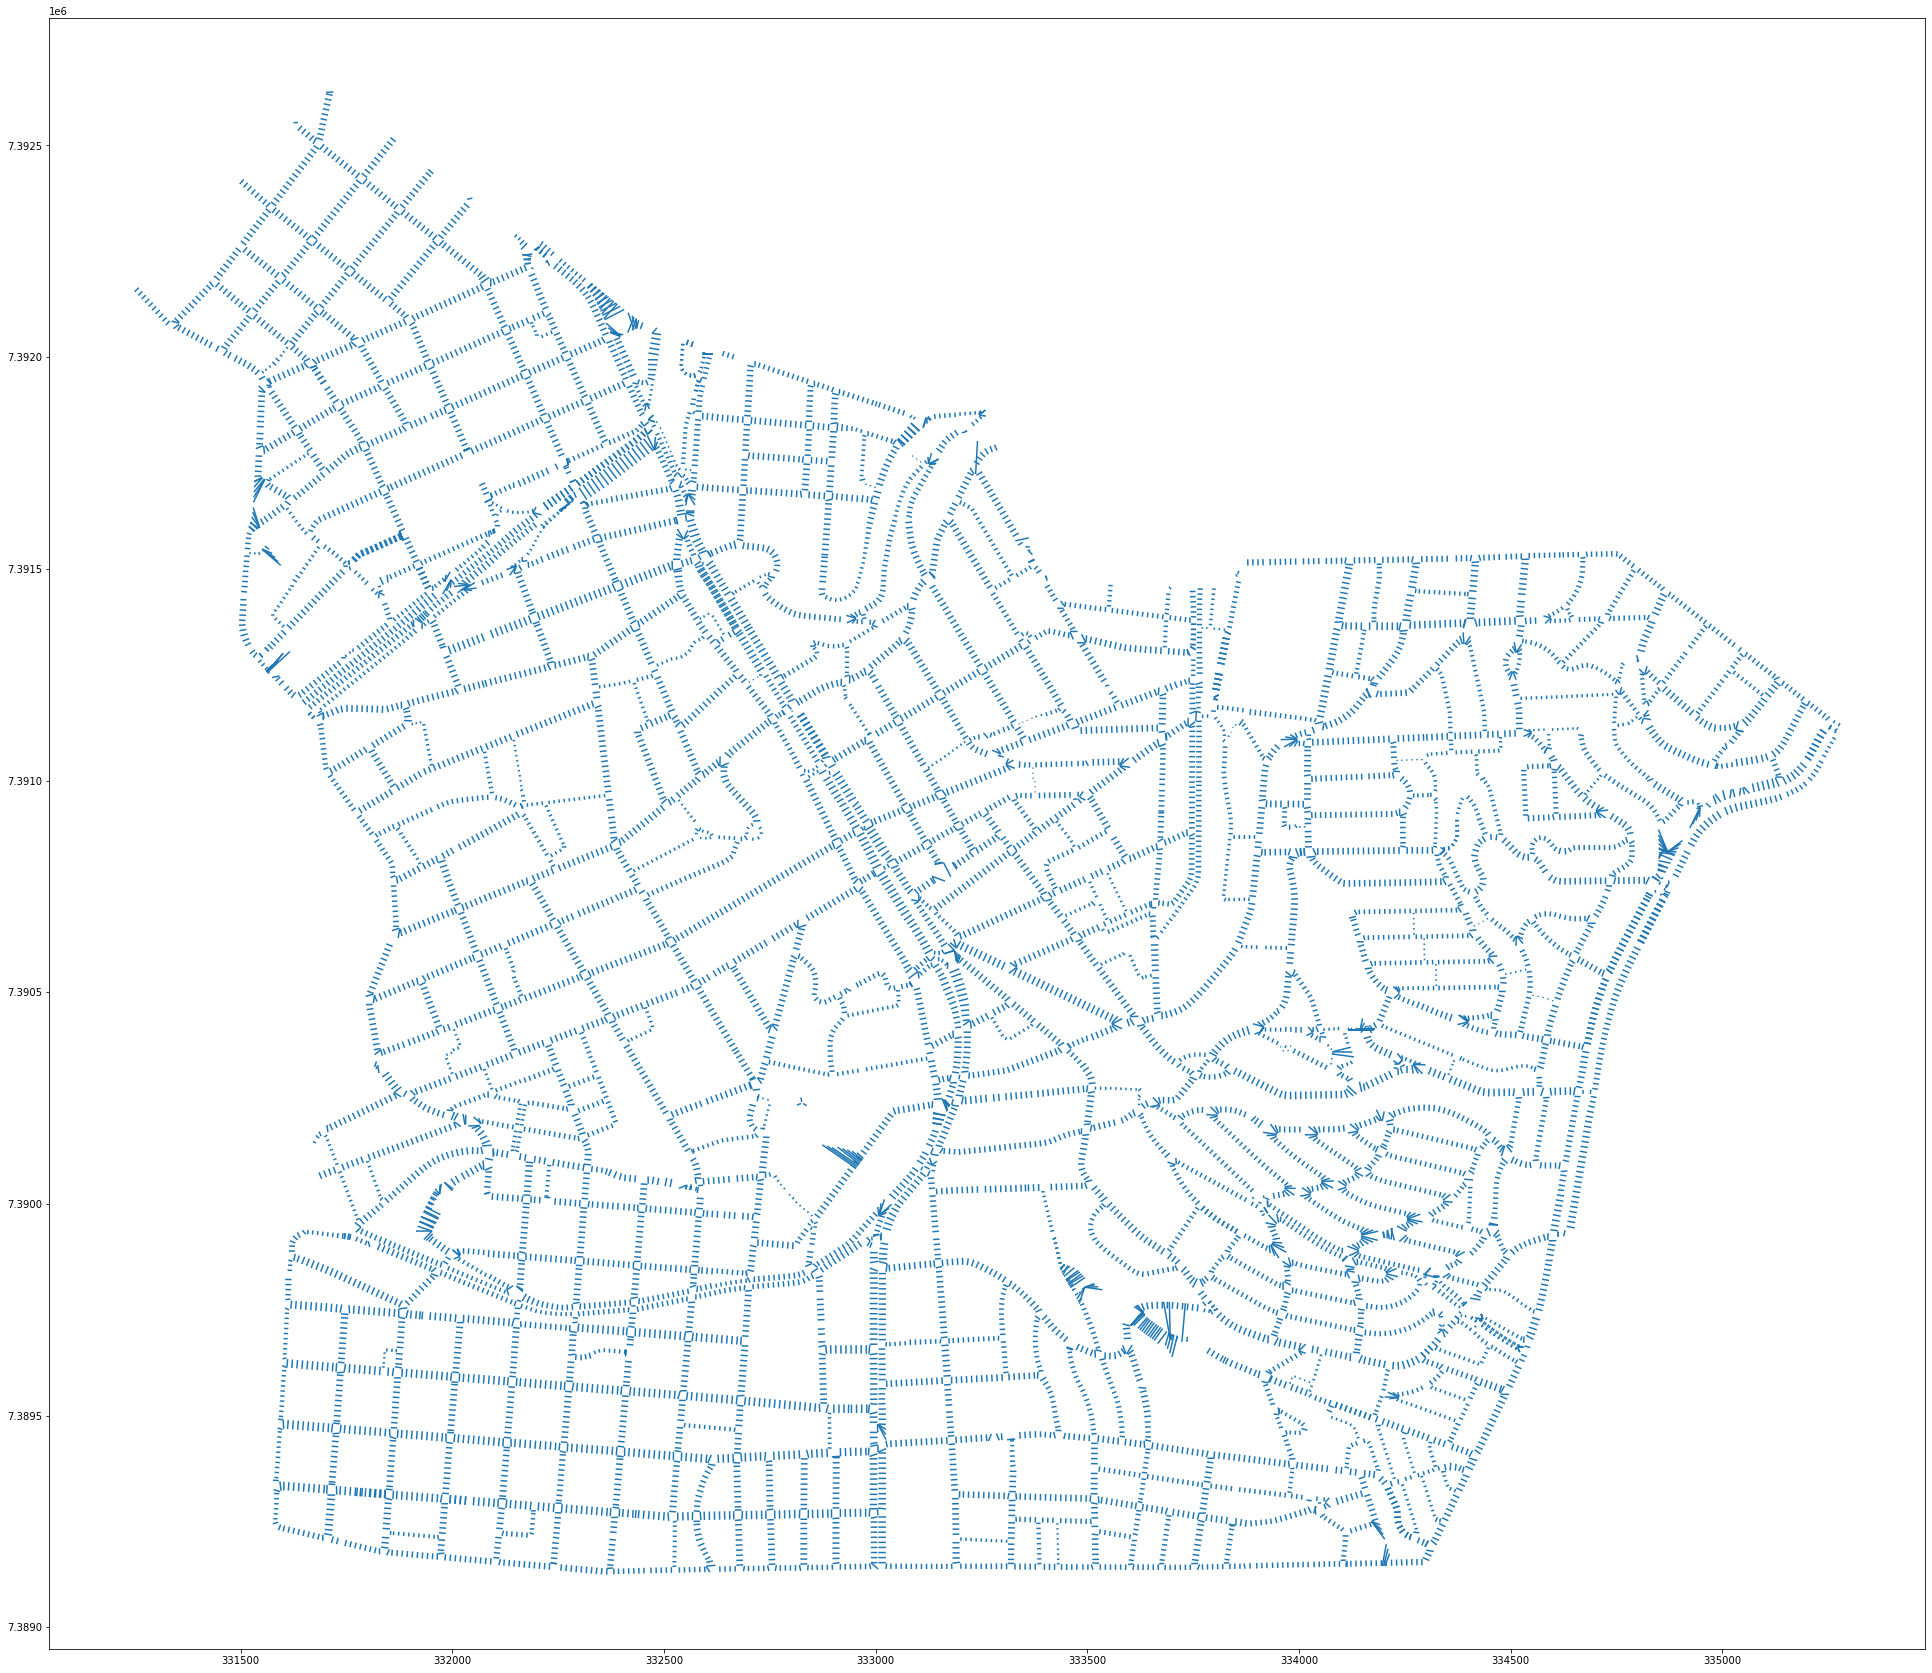

In [119]:
df_ps.plot()

In [120]:
df_ps.to_file("./resultado/largura_de_vias_90_vila_mariana.gpkg", driver="GPKG")